In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [3]:
# Load off the training and testing images
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
len(train_images), len(test_images)

(1250, 250)

In [4]:
# Select 10%
ten_perc_train = np.random.choice(train_images, len(train_images)//10)
len(ten_perc_train)

125

In [5]:
# Labels
mapping = {'car': 0, 'dog': 1, 'elephant': 2, 'cat': 3, 'airplane': 4}
labels_train_10_percent = [mapping[x.split("/")[2].split("_")[0]] for x in ten_perc_train]
labels_test = [mapping[x.split("/")[2].split("_")[0]] for x in test_images]

In [6]:
# tf.strings returns byte-strings
train_ds = tf.data.Dataset.list_files(str('imagenet-5-categories/train/*.jpg'), seed=666)
for f in train_ds.take(5):
    print(f.numpy())

b'imagenet-5-categories/train/elephant_1393028287_487e3bf3ba.jpg'
b'imagenet-5-categories/train/car_2663384793_2608e05f88.jpg'
b'imagenet-5-categories/train/airplane_2110882407_db1564e294.jpg'
b'imagenet-5-categories/train/cat_103392464_9743e196fb.jpg'
b'imagenet-5-categories/train/cat_1112640457_401418ec93.jpg'


In [7]:
LABELS = ["car", "dog", "elephant", "cat", "airplane"]

In [8]:
# Build a lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant([b'car', b'dog', b'elephant', b'cat', b'airplane']),
        values=tf.constant([0, 1, 2, 3, 4]),
    ),
    default_value=tf.constant(-1),
)

# now let us do a lookup
input_tensor = tf.constant([b'car', b'dog', b'airplane', b'cat', b'elephant'])
out = table.lookup(input_tensor)
print(out)

tf.Tensor([0 1 4 3 2], shape=(5,), dtype=int32)


In [9]:
# Image preprocessing utils
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])
    
    label = tf.strings.split(tf.strings.split(image_path, "/")[2], "_")[0]
    
    label = table.lookup(label)
    
    return image, label

In [10]:
# Prepare TensorFlow datasets

train_ds = tf.data.Dataset.from_tensor_slices(ten_perc_train)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices(test_images)
test_ds = (
    test_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [11]:
# Verification utils
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(LABELS[label_batch[n].numpy()].title())
        plt.axis('off')

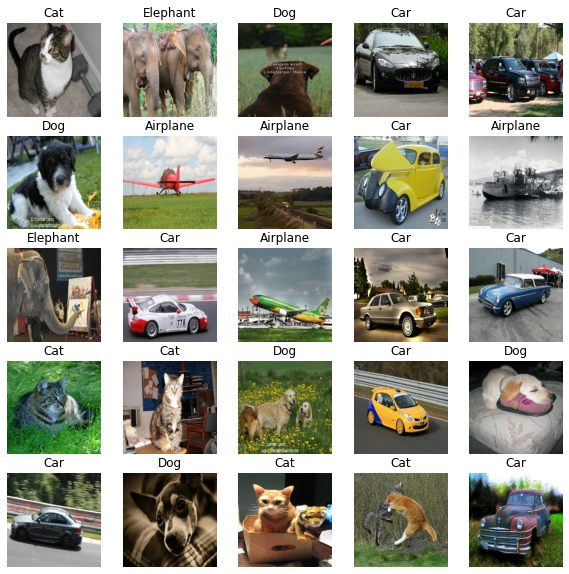

In [12]:
# Verify train images
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)

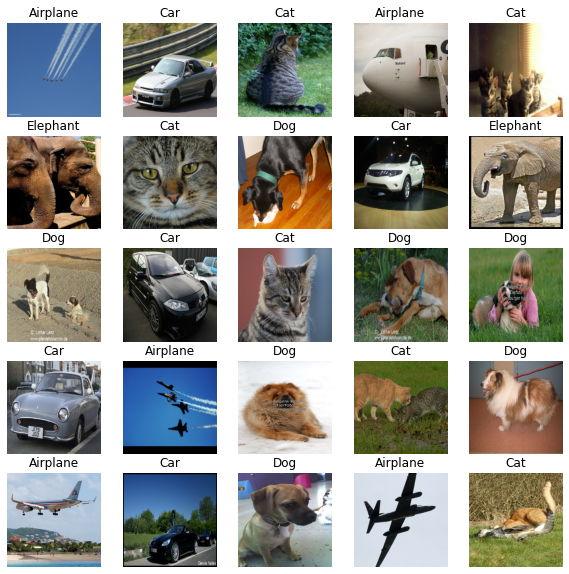

In [13]:
# Verify test images
image_batch, label_batch = next(iter(test_ds))
show_batch(image_batch, label_batch)

In [14]:
# Architecture utils
def get_resnet_simclr_deeper(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [15]:
resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("resnet_simclr/resnet_simclr_1_new.h5")
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [16]:
# We are not going to use the entire projection head
resnet_simclr_headless = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
resnet_simclr_headless.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0   

In [17]:
def get_linear_model(features):
    model = Sequential([
        Dense(5, input_shape=(features, ))
    ])
    
    return model

In [18]:
# Linear classifier
linear_classifier = get_linear_model(128)
linear_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 645       
Total params: 645
Trainable params: 645
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Loss and accuracy metric
train_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc = tf.keras.metrics.SparseCategoricalAccuracy()

In [20]:
def train_linear(epochs, simclr_variant, linear_classifier, linear_optimizer):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in range(epochs):
        for (images, labels) in train_ds:
            with tf.GradientTape() as tape:
                interm_representations = simclr_variant(images, training=False)
                y_pred = linear_classifier(interm_representations, training=True)
                loss_value = train_loss(labels, y_pred)

            gradients = tape.gradient(loss_value, linear_classifier.trainable_weights)

            linear_optimizer.apply_gradients(zip(gradients, linear_classifier.trainable_weights))

            step_wise_loss.append(loss_value.numpy())

        train_acc.reset_states()
        train_acc(labels, y_pred)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        print("epoch: {} loss: {:.3f} accuracy: {:.3f}".format(epoch+1, np.mean(step_wise_loss), 
            train_acc.result().numpy()))

## Linear evaluation on different projections

In [21]:
linear_optimizer = tf.keras.optimizers.SGD(lr=0.1)

resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("resnet_simclr/resnet_simclr_1_new.h5")
resnet_simclr_headless = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

linear_classifier = get_linear_model(128)
train_linear(50, resnet_simclr_headless, linear_classifier, linear_optimizer)

epoch: 1 loss: 9.187 accuracy: 0.230
epoch: 2 loss: 12.677 accuracy: 0.197
epoch: 3 loss: 13.893 accuracy: 0.361
epoch: 4 loss: 14.720 accuracy: 0.164
epoch: 5 loss: 15.770 accuracy: 0.197
epoch: 6 loss: 15.182 accuracy: 0.328
epoch: 7 loss: 15.652 accuracy: 0.131
epoch: 8 loss: 15.440 accuracy: 0.213
epoch: 9 loss: 15.766 accuracy: 0.295
epoch: 10 loss: 15.300 accuracy: 0.148
epoch: 11 loss: 15.701 accuracy: 0.197
epoch: 12 loss: 15.605 accuracy: 0.262
epoch: 13 loss: 15.668 accuracy: 0.115
epoch: 14 loss: 16.161 accuracy: 0.295
epoch: 15 loss: 15.685 accuracy: 0.328
epoch: 16 loss: 15.607 accuracy: 0.164
epoch: 17 loss: 15.866 accuracy: 0.164
epoch: 18 loss: 15.427 accuracy: 0.295
epoch: 19 loss: 15.337 accuracy: 0.082
epoch: 20 loss: 15.084 accuracy: 0.213
epoch: 21 loss: 15.506 accuracy: 0.180
epoch: 22 loss: 15.245 accuracy: 0.230
epoch: 23 loss: 15.087 accuracy: 0.361
epoch: 24 loss: 14.883 accuracy: 0.361
epoch: 25 loss: 14.876 accuracy: 0.213
epoch: 26 loss: 14.944 accuracy: 0.

In [22]:
linear_optimizer = tf.keras.optimizers.SGD(lr=0.1)

resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("resnet_simclr/resnet_simclr_1_new.h5")
resnet_simclr_headless = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

linear_classifier = get_linear_model(256)
train_linear(50, resnet_simclr_headless, linear_classifier, linear_optimizer)

epoch: 1 loss: 7.702 accuracy: 0.279
epoch: 2 loss: 14.801 accuracy: 0.180
epoch: 3 loss: 17.260 accuracy: 0.246
epoch: 4 loss: 17.546 accuracy: 0.230
epoch: 5 loss: 18.588 accuracy: 0.164
epoch: 6 loss: 18.691 accuracy: 0.230
epoch: 7 loss: 18.911 accuracy: 0.230
epoch: 8 loss: 19.088 accuracy: 0.180
epoch: 9 loss: 18.742 accuracy: 0.295
epoch: 10 loss: 18.509 accuracy: 0.115
epoch: 11 loss: 18.857 accuracy: 0.262
epoch: 12 loss: 18.876 accuracy: 0.377
epoch: 13 loss: 18.134 accuracy: 0.148
epoch: 14 loss: 17.777 accuracy: 0.098
epoch: 15 loss: 17.699 accuracy: 0.311
epoch: 16 loss: 17.307 accuracy: 0.262
epoch: 17 loss: 17.300 accuracy: 0.180
epoch: 18 loss: 16.934 accuracy: 0.295
epoch: 19 loss: 17.391 accuracy: 0.180
epoch: 20 loss: 17.275 accuracy: 0.197
epoch: 21 loss: 17.270 accuracy: 0.295
epoch: 22 loss: 17.459 accuracy: 0.262
epoch: 23 loss: 17.414 accuracy: 0.213
epoch: 24 loss: 17.257 accuracy: 0.311
epoch: 25 loss: 17.245 accuracy: 0.180
epoch: 26 loss: 17.115 accuracy: 0.

## Linear evaluation without any projections

In [21]:
linear_optimizer = tf.keras.optimizers.SGD(lr=0.1)

resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("resnet_simclr/resnet_simclr_1_new.h5")
resnet_simclr_headless = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

linear_classifier = get_linear_model(2048)
train_linear(50, resnet_simclr_headless, linear_classifier, linear_optimizer)

epoch: 1 loss: 23.561 accuracy: 0.230
epoch: 2 loss: 54.658 accuracy: 0.197
epoch: 3 loss: 59.945 accuracy: 0.361
epoch: 4 loss: 61.908 accuracy: 0.197
epoch: 5 loss: 61.631 accuracy: 0.164
epoch: 6 loss: 65.958 accuracy: 0.164
epoch: 7 loss: 64.567 accuracy: 0.311
epoch: 8 loss: 65.806 accuracy: 0.115
epoch: 9 loss: 65.610 accuracy: 0.246
epoch: 10 loss: 64.132 accuracy: 0.213
epoch: 11 loss: 63.750 accuracy: 0.246
epoch: 12 loss: 64.609 accuracy: 0.082
epoch: 13 loss: 62.362 accuracy: 0.328
epoch: 14 loss: 62.465 accuracy: 0.295
epoch: 15 loss: 61.609 accuracy: 0.180
epoch: 16 loss: 61.560 accuracy: 0.164
epoch: 17 loss: 60.113 accuracy: 0.361
epoch: 18 loss: 59.569 accuracy: 0.213
epoch: 19 loss: 59.435 accuracy: 0.098
epoch: 20 loss: 58.197 accuracy: 0.328
epoch: 21 loss: 57.120 accuracy: 0.344
epoch: 22 loss: 56.103 accuracy: 0.393
epoch: 23 loss: 56.615 accuracy: 0.230
epoch: 24 loss: 57.403 accuracy: 0.115
epoch: 25 loss: 58.356 accuracy: 0.197
epoch: 26 loss: 58.345 accuracy: 0

In [24]:
# Reference: https://bit.ly/2VPrSK5
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', 
                    palette=sns.color_palette("bright", 5))
    plt.legend(['car', 'dog', 'elephant','cat','airplane'])
    plt.show()

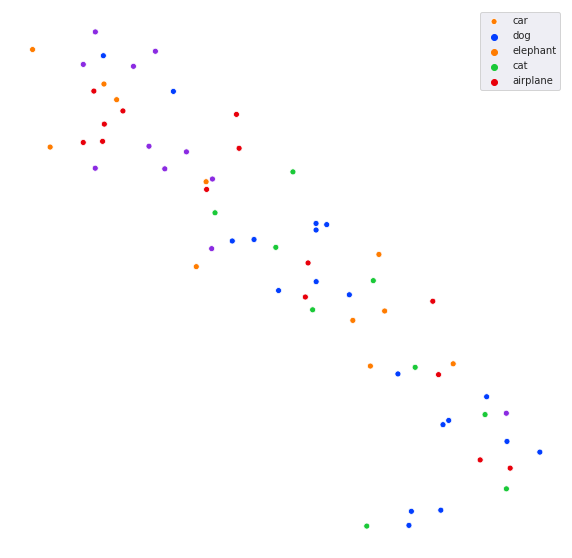

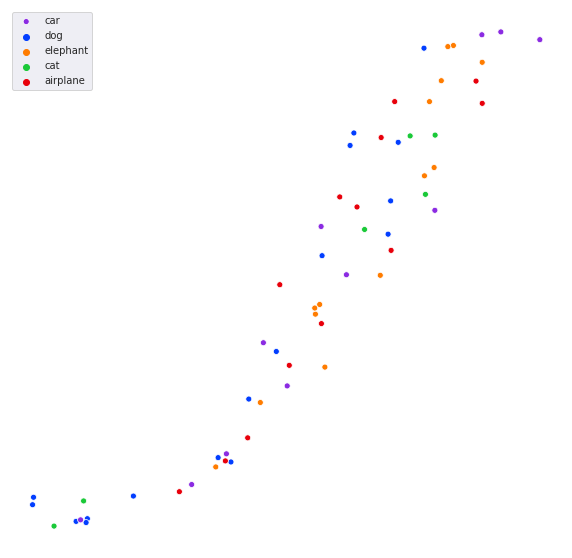

In [24]:
# Representations from second last layer (a ReLU)
tsne = TSNE()

resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("resnet_simclr/resnet_simclr_1_new.h5")
resnet_simclr = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

for (images, labels) in train_ds:
    interm_representations = resnet_simclr(images)
    y_tsne = tsne.fit_transform(interm_representations)
    plot_vecs_n_labels(y_tsne, labels.numpy())

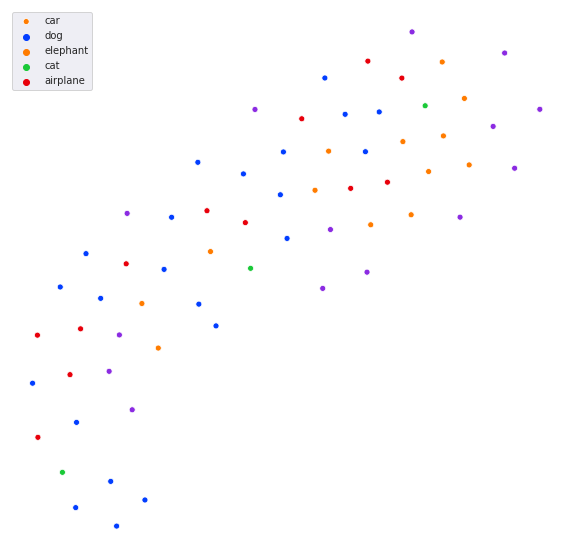

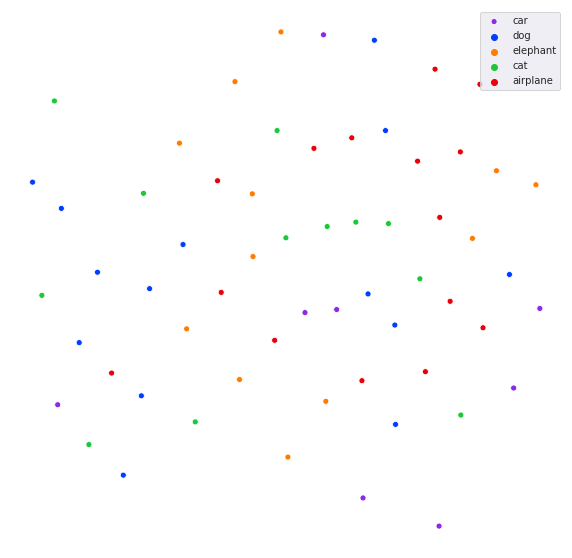

In [25]:
# Representation from the projection head less model
tsne = TSNE()

resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("resnet_simclr/resnet_simclr_1_new.h5")
resnet_simclr = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

for (images, labels) in train_ds:
    interm_representations = resnet_simclr(images)
    y_tsne = tsne.fit_transform(interm_representations)
    plot_vecs_n_labels(y_tsne, labels.numpy())